# Exploratory Data Analysis, Preprocessing, and Feature Selection on Basic Dataset

The goal of this notebook is to visualize the dataset then prepare the dataset for machine learning.

**What we know about the basic synthetic dataset already**
 - 50K rows
 - 10 features | 10% noise, 90% useful | 6 continuous, 4 binary
 - subjects were randomly assigned to treatment and control (not observational study)
 - 50% treatment rate
 - 50% response rate
 - linear relationship between x and y with no interactions
 
**Marketing Details**
 - conversions with no marketing:  25000
 - base propensity: 50%
 - conversions with marketing:  31971
 - persuadables:  6971
 - pursuadable rate: 14%

## Package and data imports

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from itertools import compress
sns.set(style="white") # white background style for seaborn plots
sns.set(style="whitegrid", color_codes=True)
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

%matplotlib inline 
sns.set()

In [64]:
filepath = '/nas/isg_prodops_work/stemr/2020/2020_03 - Capstone Project/'
basic_df = pd.read_csv(filepath + 'opossum_sim_basic.csv')

In [65]:
print(basic_df.shape)
basic_df.sample(10)

(50000, 17)


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,response_cont,exposed,true_lift,response_cont_prior,conversion,conversion_post,segments
38069,1.0,1.0,0.0,1.0,-1.895217,-2.088761,-2.367600,1.394896,0.358612,-0.345436,1.905733,1,1.602136,0.303598,0,1,persuadable
24119,0.0,1.0,1.0,0.0,1.017006,-2.591423,1.849437,0.760923,-2.803607,-3.226688,0.759997,1,0.658723,0.101275,0,1,persuadable
41781,1.0,1.0,0.0,1.0,0.371820,-1.551279,-3.884355,4.632268,-1.859203,1.338839,0.841903,1,0.457207,0.384696,0,1,persuadable
40274,1.0,1.0,0.0,1.0,0.653063,2.359577,2.404884,-0.156154,-1.734057,-1.557779,1.487939,0,0.000000,1.487939,1,1,sure_thing
4024,1.0,1.0,0.0,0.0,0.537669,-4.186744,-1.005320,2.337051,1.795596,1.230022,0.668882,0,-0.000000,0.668882,1,1,sure_thing
31529,0.0,0.0,1.0,0.0,2.834349,-0.565575,2.487963,-0.733423,-1.626648,0.229605,-0.563948,0,0.000000,-0.563948,0,0,lost_cause
18754,0.0,1.0,1.0,0.0,2.302334,-0.277285,-0.668504,-0.094039,-2.674535,3.824911,0.111206,1,0.091339,0.019868,0,0,lost_cause
22303,0.0,0.0,0.0,0.0,-0.861379,0.723387,0.769317,0.083000,-1.179591,-3.688727,0.982979,1,0.873756,0.109223,0,1,persuadable
18260,0.0,0.0,0.0,1.0,0.270012,-1.075549,0.175902,2.334780,-0.137873,-1.118112,-0.515981,1,0.143736,-0.659718,0,0,lost_cause
36602,0.0,1.0,0.0,1.0,1.844594,1.047435,-2.000652,4.092443,-0.107469,1.633335,2.956350,1,2.712011,0.244339,0,1,persuadable


In [66]:
basic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 17 columns):
feature_0              50000 non-null float64
feature_1              50000 non-null float64
feature_2              50000 non-null float64
feature_3              50000 non-null float64
feature_4              50000 non-null float64
feature_5              50000 non-null float64
feature_6              50000 non-null float64
feature_7              50000 non-null float64
feature_8              50000 non-null float64
feature_9              50000 non-null float64
response_cont          50000 non-null float64
exposed                50000 non-null int64
true_lift              50000 non-null float64
response_cont_prior    50000 non-null float64
conversion             50000 non-null int64
conversion_post        50000 non-null int64
segments               50000 non-null object
dtypes: float64(13), int64(3), object(1)
memory usage: 6.5+ MB


In [67]:
basic_df.describe()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,response_cont,exposed,true_lift,response_cont_prior,conversion,conversion_post
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,0.483060,0.494500,0.513320,0.473600,0.014925,0.004279,0.000867,-0.009002,-0.002409,-0.000696,1.070175,0.500500,0.583820,0.486355,0.500000,0.639420
std,0.499718,0.499975,0.499828,0.499308,1.881980,1.755765,1.903425,2.087731,1.903815,1.973883,1.524358,0.500005,0.907840,1.221999,0.500005,0.480174
min,0.000000,0.000000,0.000000,0.000000,-9.315095,-8.774670,-7.365795,-8.156366,-7.718844,-7.581254,-5.105610,0.000000,-2.000000,-4.644780,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,-1.247759,-1.177529,-1.275269,-1.409261,-1.282572,-1.350299,0.027706,0.000000,0.000000,-0.337477,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.000000,0.019994,0.003702,0.006521,-0.015920,0.001341,0.001307,1.013614,1.000000,0.000000,0.482968,0.500000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,1.275467,1.181821,1.279809,1.391831,1.288761,1.342840,2.079674,1.000000,1.309205,1.312582,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,8.082712,7.245996,7.939660,8.081616,7.726979,7.553827,7.128698,1.000000,3.200848,5.294043,1.000000,1.000000


## EDA

For continuous fields
 - check distributions
 - checking for multicollinearity 
 - checking relationship of each x with y

For binary fields
 - print bar charts with target variable 

In [68]:
num_df = basic_df.iloc[:,4:9]
num_df['conversion'] = basic_df['conversion']
cat_df = basic_df.iloc[:,0:4]
cat_df['conversion'] = basic_df['conversion']
cat_df

,feature_0,feature_1,feature_2,feature_3,conversion
0,0.0,1.0,1.0,0.0,0
1,0.0,0.0,0.0,1.0,1
2,0.0,0.0,0.0,0.0,1
3,0.0,1.0,0.0,0.0,1
4,1.0,1.0,0.0,0.0,0
...,...,...,...,...,...
49995,1.0,0.0,0.0,0.0,0
49996,1.0,1.0,1.0,0.0,0
49997,1.0,1.0,0.0,0.0,1
49998,0.0,0.0,0.0,0.0,0


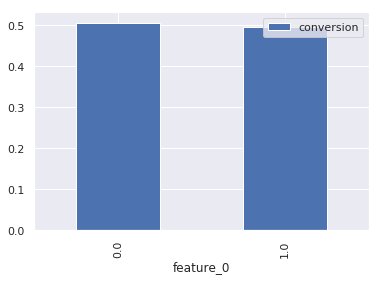

,conversion
feature_0,
0.0,0.505010
1.0,0.494638


In [69]:
## ANSWER
cat_pivot = cat_df.pivot_table(index="feature_0",values="conversion")
cat_pivot.plot.bar()
plt.show();
cat_pivot

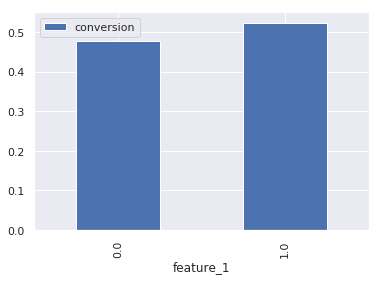

,conversion
feature_1,
0.0,0.476716
1.0,0.523802


In [70]:
## ANSWER
cat_pivot = cat_df.pivot_table(index="feature_1",values="conversion")
cat_pivot.plot.bar()
plt.show();
cat_pivot

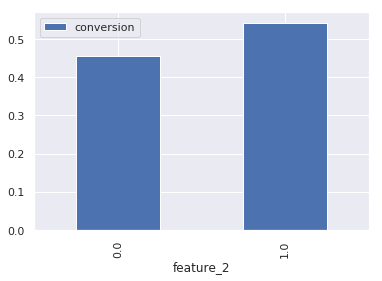

,conversion
feature_2,
0.0,0.455494
1.0,0.542196


In [71]:
## ANSWER
cat_pivot = cat_df.pivot_table(index="feature_2",values="conversion")
cat_pivot.plot.bar()
plt.show();
cat_pivot

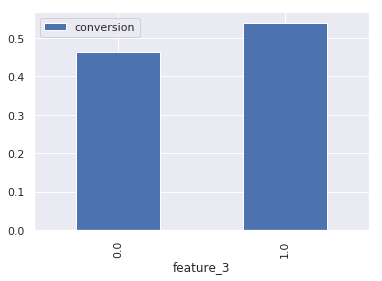

,conversion
feature_3,
0.0,0.464134
1.0,0.539865


In [72]:
## ANSWER
cat_pivot = cat_df.pivot_table(index="feature_3",values="conversion")
cat_pivot.plot.bar()
plt.show();
cat_pivot

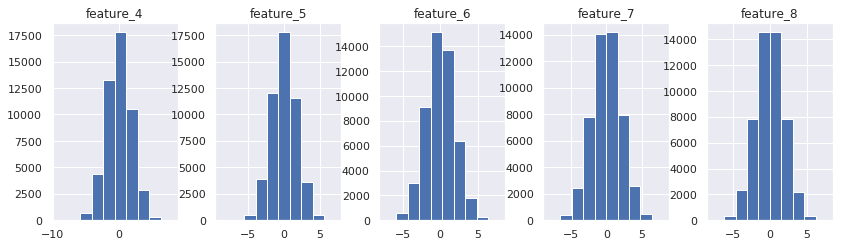

In [73]:
#histogram of every base x variable
num_df.iloc[:,0:5].hist(figsize=(14, 32), layout=(7, 5));

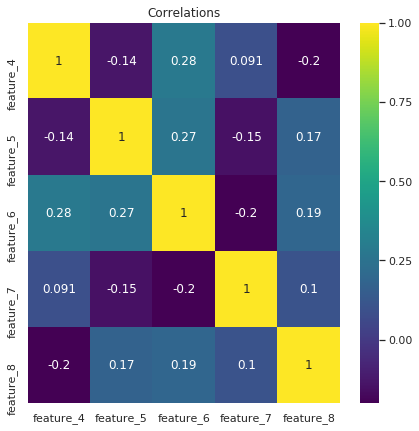

In [74]:
plt.subplots(figsize=(7, 7))
sns.heatmap(num_df.iloc[:,0:5].corr(), annot=True, cmap="viridis").set_title("Correlations")
plt.show();

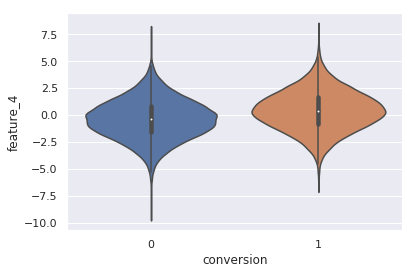

In [75]:
ax = sns.violinplot(x="conversion", y="feature_4", data=num_df)

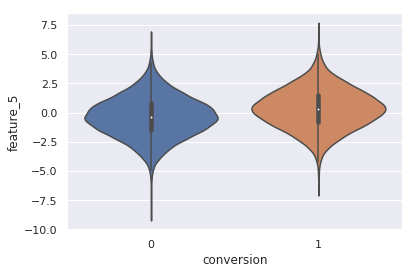

In [76]:
ax = sns.violinplot(x="conversion", y="feature_5", data=num_df)

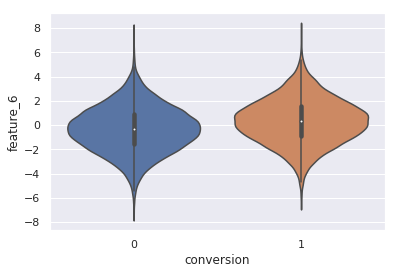

In [77]:
ax = sns.violinplot(x="conversion", y="feature_6", data=num_df)

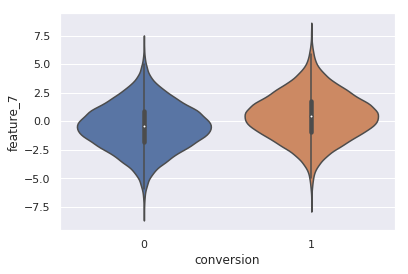

In [78]:
ax = sns.violinplot(x="conversion", y="feature_7", data=num_df)

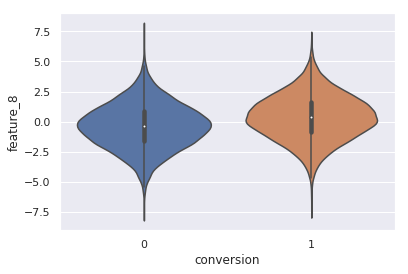

In [79]:
ax = sns.violinplot(x="conversion", y="feature_8", data=num_df)

## Feature Selection

### Univariate Logistic CV AUC Importance

In [80]:
feature_names = list(basic_df.columns[0:10])
target_name = 'conversion'

In [81]:
result_dict = {}
for i in feature_names:
    x = basic_df[[i]]
    y = basic_df[target_name]
    log_model = LogisticRegression()
    result_dict['{}'.format(i)] = np.mean(cross_val_score(log_model, x, y, cv=5, scoring='roc_auc'))
result_frame = pd.DataFrame.from_dict(result_dict, orient='index', columns=['cv_score'])
result_frame.sort_values(by='cv_score', ascending = False)

,cv_score
feature_7,0.623313
feature_4,0.618476
feature_5,0.612063
feature_8,0.610229
feature_6,0.597760
feature_2,0.543320
feature_9,0.542241
feature_3,0.537760
feature_1,0.523540
feature_0,0.505180


### RFE

In [82]:
feature_names = list(basic_df.columns[0:9])
target_name = 'conversion'

In [83]:
## feature selection test train split
x = basic_df[feature_names]
y = basic_df[target_name]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [84]:
log_model = LogisticRegression()
#Initializing RFE model
rfe = RFE(log_model)
#Transforming data using RFE
x_rfe = rfe.fit_transform(x_train,y_train)  
#Fitting the data to model
log_model.fit(x_train,y_train)
print(rfe.support_)
print(rfe.ranking_)

[False  True False  True  True False False False  True]
[5 1 3 1 1 2 6 4 1]


In [85]:
print('winning features')
list(compress(feature_names, rfe.ranking_<=3))

winning features


['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_8']

### RF Feature Selection
RF Variable importance will favor continuous variables because they have more random splitting opportunities running the feature types separate.

In [86]:
feature_names = list(basic_df.columns[0:10])
target_name = 'conversion'

In [87]:
## feature selection test train split
x = basic_df[feature_names]
y = basic_df[target_name]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [88]:
model = RandomForestClassifier(n_estimators=300, max_depth=3, max_features=3)
model.fit(x_train,y_train)
importances = model.feature_importances_

In [89]:
importance_df = pd.DataFrame(model.feature_importances_,
                                   index = x_train.columns,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)

In [90]:
importance_df

,importance
feature_7,0.255358
feature_4,0.245391
feature_5,0.198878
feature_8,0.166628
feature_6,0.097703
feature_2,0.013680
feature_3,0.012394
feature_9,0.008863
feature_1,0.001105
feature_0,0.000000


Based on both univariate logistic and random forest variable importance, feature_0 seems to be not useful in predicting conversion.